## Preprocess the dataset

### Import libraries and datasets

In [2]:
# Import all libraries needed.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
# Imports for KNN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE


In [ ]:
# Load each dataset
monday = pd.read_csv('drive/MyDrive/dataset/Monday-WorkingHours.pcap_ISCX.csv')
tuesday = pd.read_csv('drive/MyDrive/dataset/Tuesday-WorkingHours.pcap_ISCX.csv')
wednesday = pd.read_csv('drive/MyDrive/dataset/Wednesday-workingHours.pcap_ISCX.csv')
thursday = pd.read_csv('drive/MyDrive/dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
friday_ddos = pd.read_csv('drive/MyDrive/dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
friday_portscan = pd.read_csv('drive/MyDrive/dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')

# Add a 'Day' column
monday['Day'] = 'Monday'
tuesday['Day'] = 'Tuesday'
wednesday['Day'] = 'Wednesday'
thursday['Day'] = 'Thursday'
friday_ddos['Day'] = 'Friday-DDOS'
friday_portscan['Day'] = 'Friday-PortScan'

# Combine all datasets
all_data = pd.concat([monday, tuesday, wednesday, thursday, friday_ddos, friday_portscan], ignore_index=True)

# Display combined dataset info
print(all_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351108 entries, 0 to 2351107
Data columns (total 80 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

### Clean the dataset

In [ ]:
# Calculate the threshold for keeping rows (50% of total columns)
threshold = len(all_data.columns) / 2

# Drop rows with more than 50% missing values
data_cleaned = all_data.dropna(thresh=threshold)

print("Number of rows before cleaning:", len(all_data))
print("Number of rows after cleaning:", len(data_cleaned))

# Separate numerical and categorical columns
numerical_cols = data_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data_cleaned.select_dtypes(include=['object', 'category']).columns

# Replace inf and -inf with NaN
data_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

# Cap extremely large values only for numerical columns
max_threshold = 1e6
data_cleaned[numerical_cols] = data_cleaned[numerical_cols].clip(upper=max_threshold)

# Impute numerical columns
imputer = IterativeImputer(random_state=42)
data_cleaned[numerical_cols] = imputer.fit_transform(data_cleaned[numerical_cols])

# Encode categorical columns
encoder = LabelEncoder()
for col in categorical_cols:
    data_cleaned[col] = encoder.fit_transform(data_cleaned[col].astype(str))

# Verify imputation
print("Missing values after imputation:")
print(data_cleaned.isnull().sum())

Number of rows before cleaning: 2351108
Number of rows after cleaning: 2351108
Missing values after imputation:
 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
 Label                         0
Day                            0
Length: 80, dtype: int64


In [ ]:
# Total number of missing values across all columns
total_missing = data_cleaned.isnull().sum().sum()

print(f"Total number of missing values in the dataset: {total_missing}")
# Save the cleaned dataset to a CSV file
data_cleaned.to_csv('cleaned_dataset.csv', index=False)

# Copy the cleaned dataset to use it everywhere
all_data = data_cleaned

Total number of missing values in the dataset: 0


In [3]:
all_data = pd.read_csv('drive/MyDrive/dataset/cleaned_dataset.csv')

```IterativeImputer```:
- This is a scikit-learn imputation class that fills missing values in numerical data.
- It uses a multivariate approach: missing values are predicted based on other columns using a regression model.
- It works iteratively: each feature with missing values is modeled as a function of other features, and the process is repeated multiple times for refinement.
```.fit_transform()```:
- fit(): Learns the patterns and relationships in the data to create a model for imputing missing values.
- transform(): Applies the learned imputation model to fill the missing values.



### Exploring the data

In [ ]:
# Summary of the dataset
print(all_data.describe())

        Destination Port   Flow Duration   Total Fwd Packets  \
count       2.351108e+06    2.351108e+06        2.351108e+06   
mean        8.163563e+03    3.337319e+05        9.382722e+00   
std         1.849374e+04    4.445273e+05        7.603036e+02   
min         0.000000e+00   -1.300000e+01        1.000000e+00   
25%         5.300000e+01    1.630000e+02        1.000000e+00   
50%         8.000000e+01    3.574800e+04        2.000000e+00   
75%         4.430000e+02    1.000000e+06        5.000000e+00   
max         6.553500e+04    1.000000e+06        2.197590e+05   

        Total Backward Packets  Total Length of Fwd Packets  \
count             2.351108e+06                 2.351108e+06   
mean              1.041678e+01                 5.409034e+02   
std               1.009094e+03                 5.117577e+03   
min               0.000000e+00                 0.000000e+00   
25%               1.000000e+00                 1.200000e+01   
50%               2.000000e+00               

Label
0     1795464
3      231073
8      158930
1      128027
2       10293
6        7938
9        5897
5        5796
4        5499
10       1507
12        652
11         21
7          11
Name: count, dtype: int64


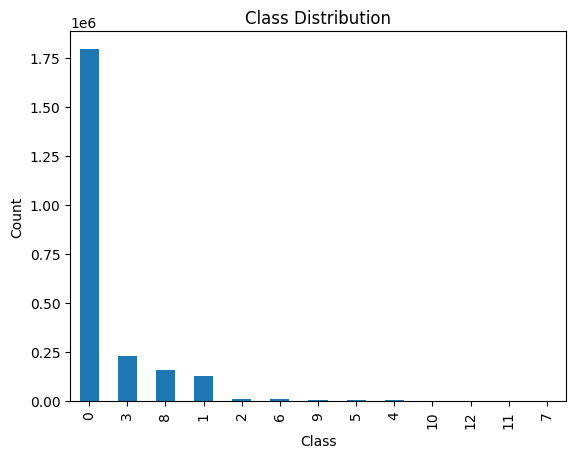

In [4]:
# Strip leading and trailing whitespace from column names
all_data.columns = all_data.columns.str.strip()

# Now access the 'Label' column
print(all_data['Label'].value_counts())

all_data['Label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

                              min         max
Destination Port             22.0    61948.93
Flow Duration                 1.0  1000000.00
Total Fwd Packets             1.0       47.00
Total Backward Packets        0.0       55.00
Total Length of Fwd Packets   0.0    11601.00
...                           ...         ...
Idle Std                      0.0  1000000.00
Idle Max                      0.0  1000000.00
Idle Min                      0.0  1000000.00
Label                         0.0        8.00
Day                           0.0        5.00

[80 rows x 2 columns]


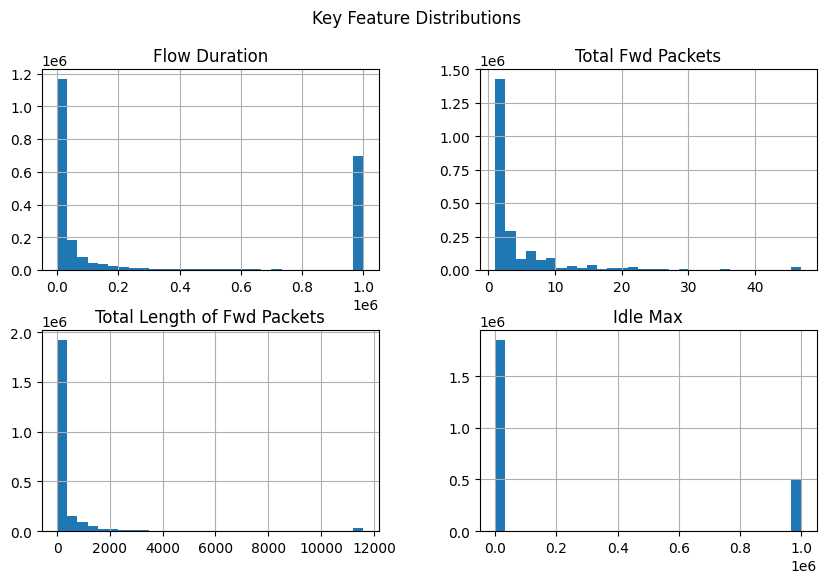

In [5]:
# Select numerical columns
numerical_columns = all_data.select_dtypes(include=['number']).columns

# Cap extreme values at the 1st and 99th percentiles
for col in numerical_columns:
    lower_bound = all_data[col].quantile(0.01)  # 1st percentile
    upper_bound = all_data[col].quantile(0.99)  # 99th percentile
    all_data[col] = all_data[col].clip(lower=lower_bound, upper=upper_bound)

# Verify the new range
print(all_data[numerical_columns].agg(['min', 'max']).T)

# List of key features
key_features = ['Flow Duration', 'Total Fwd Packets', 'Total Length of Fwd Packets', 'Idle Max']

# Plot histograms for key features
all_data[key_features].hist(figsize=(10, 6), bins=30)
plt.suptitle('Key Feature Distributions')
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


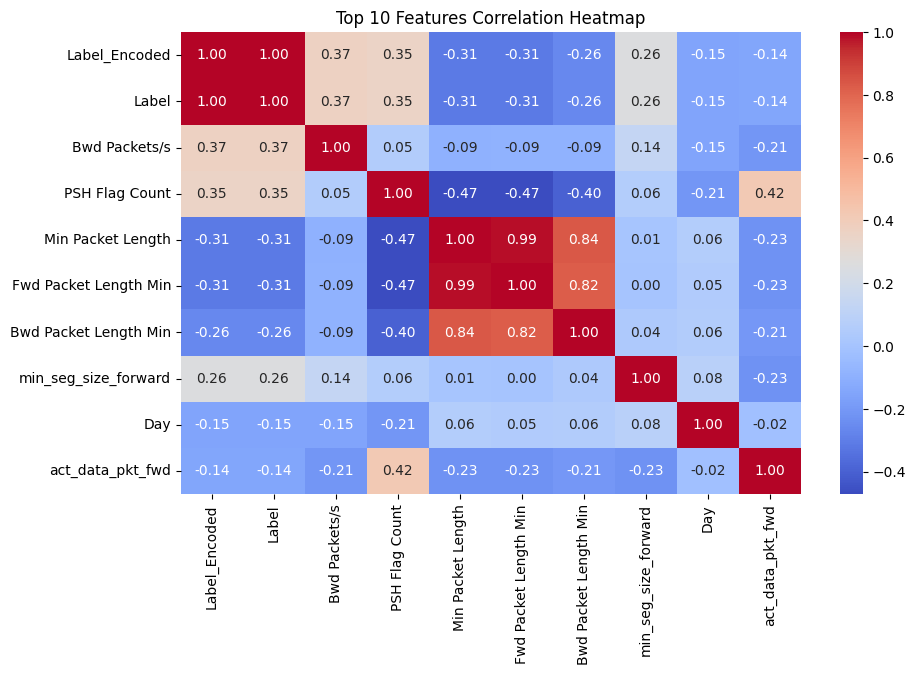

In [6]:
# Encode the 'Label' column
le = LabelEncoder()
all_data['Label_Encoded'] = le.fit_transform(all_data['Label'])
numerical_data = all_data.select_dtypes(include=['number'])

# Recalculate correlations with the target variable (Label_Encoded)
target_corr = numerical_data.corrwith(all_data['Label_Encoded']).abs().sort_values(ascending=False)

# Select top 10 most correlated features
top_features = target_corr.head(10).index

# Plot heatmap for top features
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(numerical_data[top_features].corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Top 10 Features Correlation Heatmap')
plt.show()

Standardization. We choose to use the standardization because it's better to detect outliers because of its outlier sensitivity.

In [ ]:
# Calculate the Z score
z_scores = np.abs(zscore(all_data[numerical_columns]))

# identifiy outliers
outliers = np.where(z_scores > 3)
print("Outliers found at : ", outliers)

Outliers found at :  (array([      0,       1,       1, ..., 2351107, 2351107, 2351107]), array([48, 15, 36, ..., 64, 65, 68]))


For this project, the best choice is to choose a supervised learning because we have a labeled data, the supervised learning is very effective to classified, so it's good for us because we need to classify attacks in categories.
Later, we could implement also unsupervised learning to further our analysis.  
The best choice seems to be KNN algorithm because we have a labeled dataset, we have multiple attack classes. KNN is good to handle multiclass problems effectively

We'll start by prepare the dataset for the training. Starting by defining features and target variable and split it into training and testing sets.

In [ ]:
# Define features and target variable
X = all_data[top_features] # Top correlated features from preprocessing
y = all_data['Label_Encoded']

# Split the dataset into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (1645775, 10)
Test set size: (705333, 10)


Now, let's initialize and tain the KNN model

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Standardize the training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Standardized Training Data:")
print(X_train[:5])
# Initialize the KNN model
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model on the training set
knn.fit(X_train, y_train)
print(knn)

Standardized Training Data:
[[-0.44261691 -0.44261691 -0.44039343 -0.63990524  1.19149739  1.16089033
   0.83092654  0.87633733  1.15307665 -0.30029962]
 [-0.44261691 -0.44261691 -0.4433034   1.56273139 -0.74577171 -0.74852563
  -0.64722667 -0.93947771 -1.17844426 -0.05739323]
 [-0.44261691 -0.44261691 -0.44333513 -0.63990524 -0.74577171 -0.74852563
  -0.64722667  0.87633733  0.57019642 -0.30029962]
 [-0.44261691 -0.44261691 -0.44039014 -0.63990524  1.82110985  1.78145052
   0.71334617 -0.93947771  1.15307665 -0.54320602]
 [-0.44261691 -0.44261691 -0.44118415  1.56273139 -0.74577171 -0.74852563
  -0.64722667 -0.93947771 -1.17844426 -0.05739323]]
KNeighborsClassifier()


Now, let's make predictions with our test set

In [ ]:
# Predict on the test set
y_pred = knn.predict(X_test)

We'll evaluate the performacne using metrics like precision, recall, F1-score and confusion matrix to see the accuracy of our model

In [ ]:
# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    538640
           1       1.00      1.00      1.00     38408
           2       1.00      1.00      1.00      3088
           3       1.00      1.00      1.00     69322
           4       1.00      1.00      1.00      1650
           5       1.00      1.00      1.00      1739
           6       1.00      1.00      1.00      2381
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00     50102

    accuracy                           1.00    705333
   macro avg       1.00      1.00      1.00    705333
weighted avg       1.00      1.00      1.00    705333

Confusion Matrix:
[[538640      0      0      0      0      0      0      0      0]
 [     1  38407      0      0      0      0      0      0      0]
 [     0      0   3088      0      0      0      0      0      0]
 [     0      0      0  69322      0      0      0      

**Performance**

Here, we can observe that the model works very well. Almost all categories have a F1-score of 1, meaning the model performs well with no false positive and true negative.
There is class 7 and 11 that does not have all at 1.
- Class 7 has a recall of 0.75, meaning 25% of this instance were not correctly classified.
- Class 11 has a recall of 0.83 , meaning it also misses some instances (17%).

**Confusion matrix**
- Class 7: Out of 4 actual instances, only 3 were correctly classified, and 1 was misclassified as Class 8.
- Class 11: Out of 6 actual instances, 5 were correctly classified, and 1 was misclassified as Class 12.

### Random Forest

In [7]:
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

all_data = all_data[all_data['Label_Encoded'] != 7]

# Remap class labels to be contiguous
remap_labels = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 8: 7}
all_data['Label_Encoded'] = all_data['Label_Encoded'].map(remap_labels)

# Features and target variable
X = all_data[top_features].drop(columns=['Label', 'Label_Encoded'])  # Drop redundant features
y = all_data['Label_Encoded']

# Update the feature matrix and target variable
X = X[y != 7]
y = y[y != 7]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(k_neighbors=3)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())




<ipython-input-7-093bb62e2b3f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data['Label_Encoded'] = all_data['Label_Encoded'].map(remap_labels)


Class distribution after SMOTE:
Label_Encoded
0    1256598
3    1256598
1    1256598
2    1256598
5    1256598
4    1256598
6    1256598
Name: count, dtype: int64


In [ ]:
# Train Random Forest on the balanced data
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Predict
y_pred = rf_model.predict(X_test)

In [ ]:
# Evaluate
print("Classification Report:")
print(classification_report(y_test, y_pred))

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.show()

Classification Report:


NameError: name 'y_pred' is not defined

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross-validation with F1-macro score
scores = cross_val_score(rf_model, X, y, cv=cv, scoring='f1_macro')

# Print cross-validation results
print("Cross-Validation F1-Macro Scores:", scores)
print("Mean F1-Macro Score:", scores.mean())

Cross-Validation F1-Macro Scores: [0.81974949 0.81773052 0.84281707 0.85317382 0.83959169]
Mean F1-Macro Score: 0.8346125171283398


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Step 1: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2: Define pipeline with SMOTE and Random Forest
pipeline = Pipeline([
    ('smote', SMOTE(k_neighbors=3, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Step 3: Perform cross-validation on the training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1_macro')

print("Cross-Validation F1-Macro Scores on Training Set:", cv_scores)
print("Mean F1-Macro Score:", cv_scores.mean())

# Step 4: Train on the full training set and evaluate on the test set
pipeline.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
y_pred = pipeline.predict(X_test)

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    538679
           1       0.99      1.00      0.99     38327
           2       0.58      0.71      0.64      3151
           3       0.90      0.99      0.94     69217
           4       0.44      0.96      0.60      1668
           5       0.62      0.70      0.66      1722
           6       0.30      0.98      0.46      2361
           7       1.00      0.75      0.86         4
           8       0.93      0.99      0.96     50204

    accuracy                           0.97    705333
   macro avg       0.75      0.89      0.79    705333
weighted avg       0.98      0.97      0.97    705333



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:12:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    538866
           1       0.98      1.00      0.99     38287
           2       0.46      0.75      0.57      3031
           3       0.89      0.99      0.94     69379
           4       0.42      0.97      0.58      1608
           5       0.52      0.70      0.60      1720
           6       0.26      1.00      0.41      2336

    accuracy                           0.97    655227
   macro avg       0.65      0.91      0.73    655227
weighted avg       0.98      0.97      0.97    655227



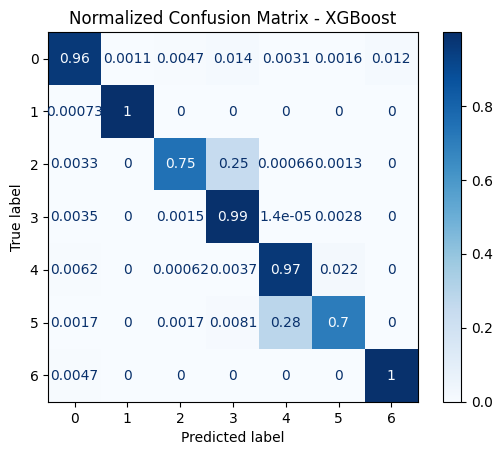

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:13:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:14:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:14:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:14:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: 

In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt

# Initialize the XGBoost classifier with GPU support
xgb_model = XGBClassifier(
    n_estimators=1600,            # Number of trees
    max_depth=6,                 # Maximum depth of a tree
    learning_rate=0.2,           # Step size shrinkage
    scale_pos_weight=1,          # Adjusts for class imbalance
    use_label_encoder=False,     # Disable old label encoding method
    random_state=42,
    tree_method="hist",       # Use GPU-accelerated histogram method
    device="cuda",
    n_jobs=3000
)

# Train the XGBoost model on balanced data
xgb_model.fit(X_train_balanced, y_train_balanced)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(cmap='Blues')
plt.title("Normalized Confusion Matrix - XGBoost")
plt.show()

# Define Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='f1_macro')

print("Cross-Validation F1-Macro Scores:", cv_scores)
print("Mean F1-Macro Score:", cv_scores.mean())

# Grid Search with GPU
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 800, 1600],
    'max_depth': [3, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [1, 2, 5]
}

# Grid Search with GPU support
grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, random_state=42, tree_method="hist", device="cuda", n_jobs=3000),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=1
)

grid_search.fit(X_train_balanced, y_train_balanced)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Supposons que grid_search.best_params_ est un dictionnaire
best_params = grid_search.best_params_

# Définir le chemin dans Google Drive
file_path = '/content/drive/MyDrive/best_params.txt'

# Sauvegarder dans un fichier texte
with open(file_path, 'w') as f:
    f.write(str(best_params))

print(f"Les paramètres optimaux ont été sauvegardés dans : {file_path}")

In [11]:

!nvidia-smi

Wed Dec  4 19:17:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              54W / 400W |   1399MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--